# Imports and utility functions

In [4]:
import numpy as np
import pandas as pd
import re
from pandas import DataFrame
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import matplotlib as mpl
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import csv
import denials_config # contains sensitive data (git ignored)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn import linear_model, decomposition, datasets
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.serif'] = ['Times New Roman']

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [ ]:
# Utility function to test 
def train_model(X, y, classifier):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        X, y, test_size=0.2, random_state=20)

    model = classifier.fit(X_train, y_train)
    
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))

    print("Training accuracy is {0}".format(model.score(X_train, y_train)))
    print("Testing accuracy is {0}".format(model.score(X_test, y_test)))
    print("Precision is {0}".format(precision))
    print("Recall is {0}".format(recall))

    return model, X_test, y_test, X_train, y_train

In [20]:
# Simple function to prettify chart axes
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Data downloading

First, we pull down all of the patents that have ever been brought before the PTAB and join with patent text.

In [ ]:
# Connecting to the db
host_db = "cal-patent-lab.chhaitskv8dz.us-west-2.rds.amazonaws.com"
username = denials_config.team_username
password = denials_config.team_password
db = "***REMOVED***"

engine = create_engine("mysql://{}:{}@{}/{}".format(
    username, password, host_db, db))
connection = engine.connect()
q = "SELECT case_id, patent_id, invalidated, denied, filing_date, decision_date FROM ptab_cases"
ptab_patents = pd.read_sql(q, engine)
connection.close()

In [19]:
# Next, we want to grab the claims text associated with each patent and insert it into the dataframe

host_db = "rosencrantz.berkeley.edu"
username = denials_config.fung_username
password = denials_config.fung_password
db = "uspto"

engine = create_engine("mysql://{}:{}@{}/{}".format(
    username, password, host_db, db))
connection = engine.connect()

patent_id = int(ptab_patents.patent_id[:1])

In [ ]:
# Inserting concatenated claim text into ptab_patents

found = list()
for idx, patent_id in enumerate(ptab_patents.patent_id):
    q = "SELECT text from uspto.claim where patent_id = '{}'".format(patent_id)
    claims = pd.read_sql(q, engine)
    claims_concat = claims.text.str.cat()
    ptab_patents.loc[ptab_patents.patent_id == '{}'.format(patent_id), 'claim_text'] = claims_concat
    found.append(not claims.empty)
    if idx % 100 == 0:
        print("Processing patent {}".format(idx))

In [106]:
# Pickling file for later use -- uncomment this line to overwrite the existing pickle
# ptab_patents.to_pickle('ptab_patents.pkl')

# Overall data description histogram

In [32]:
ptab_patents = pd.read_pickle('./pickles/ptab_patents.pkl')
num_denied = ptab_patents[ptab_patents.denied == 1].count()[0]

2052

# Data cleaning

In [15]:
ptab_patents = pd.read_pickle('./pickles/ptab_patents.pkl')

# First get rid of patents where we cannot find the claim text
mask = (ptab_patents.claim_text.str.len() > 1)
df = ptab_patents.loc[mask]

null_denied_counts = df.denied.notnull().value_counts()
print("Out of {0} total cases, {1} have null for their denied status".format(sum(null_denied_counts), null_denied_counts[1]))

Out of 4273 total cases, 2490 have null for their denied status


In [16]:
null_denied_counts

True     2490
False    1783
Name: denied, dtype: int64

In [18]:
dup_patent_counts = df.duplicated(subset='patent_id', keep='first').value_counts()
print("{0} patents show up more than once".format(dup_patent_counts[1]))

1656 patents show up more than once


## Inferring denied status when possible

In [21]:
# First we want to represent the null denial status with an actual value — we'll use -1 for this (0 means not denied, 1 means denied)

df.denied = df.denied.fillna(value=-1)
df.invalidated = df.invalidated.fillna(value=-1)
df.invalidated.value_counts()

/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


-1.0    1783
 0.0    1527
 1.0    963 
Name: invalidated, dtype: int64

In [22]:
stacked = df.groupby(by=['denied', 'invalidated']).count()
unstacked = stacked.unstack()
unstacked['case_id']

invalidated,-1.0,0.0,1.0
denied,,,
-1.0,1783.0,NaN,NaN
0.0,NaN,140.0,963.0
1.0,NaN,1387.0,NaN


As we'd expect, almost all of the cases that were not denied had a ruling. There are no cases that were both invalidated and denied (which makes sense). We'd lose a significant amount of data by calling all cases that are denied "denied." We can get around this by counting all of the cases that have an invalidation decision as not denied. 

In [23]:
df['filing_to_decision'] = df.decision_date - df.filing_date

/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Average number of days elapsed is 171.034941764


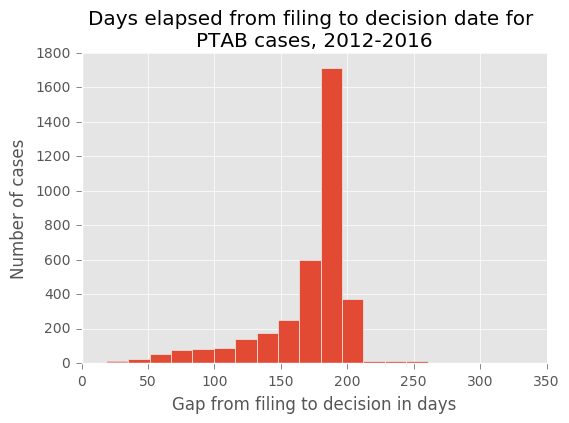

In [24]:
gap_in_days = df.filing_to_decision[df.filing_to_decision.notnull()] / np.timedelta64(1, 'D')
ax = plt.subplot(111)
gap_in_days.hist(bins=20)
simpleaxis(ax)
plt.title('Days elapsed from filing to decision date for \nPTAB cases, 2012-2016')
plt.xlabel('Gap from filing to decision in days')
plt.ylabel('Number of cases')
print("Average number of days elapsed is {0}".format(gap_in_days.mean()))

So it looks like, for all cases from more than 200 days prior to when this case was filed, if there is no decision we can count them as "denied" for the purposes of our algorithm.

In [25]:
# Eliminate any missing within the acceptable filing-to-decision gap

df.decision_date = pd.to_datetime(df.decision_date)
df.filing_date = pd.to_datetime(df.filing_date)

max_date = df.decision_date.max()
min_filing_date = max_date - pd.Timedelta('200 days')

n_should_be_denied = df[((df.denied == -1) & (df.filing_date < min_filing_date))].count()[0]
n_out_of_progress_period = df[(df.filing_date < min_filing_date)].count()[0]
n_in_progress_period = df[(df.filing_date >= min_filing_date)].count()[0]

In [26]:
df = df[(df.denied == 1) | (df.denied == 0) | ((df.denied == -1) & (df.filing_date < min_filing_date))]
df.denied[df.denied == -1] = 1

In [33]:
df.denied.value_counts()

1.0    2541
0.0    1103
Name: denied, dtype: int64

That increased the amount that we have to work with from ~2500 to ~3600 – a pretty substantial increase!

# Feature engineering
## Removing stop words and applying stemmer

In [36]:
X = df.claim_text.as_matrix()
y = df.denied.as_matrix()

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
ps = SnowballStemmer('english')

stop = set(stopwords.words('english'))
X_mod = []
for idx, claim in enumerate(X):
    try:
        text = ' '.join([ps.stem(word) for word in claim.split() if word not in stop])
    except:
        text = ' '.join([word for word in claim.split() if word not in stop])
    X_mod.append(text)

## Plotting number of features by featurization method

In [21]:
tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1))
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2))
tfidf_trigram = TfidfVectorizer(ngram_range=(1, 3))
tfidf_tetragram = TfidfVectorizer(ngram_range=(1, 4))

X_unigram = tfidf_unigram.fit_transform(X_mod)
X_bigram = tfidf_bigram.fit_transform(X)
X_trigram = tfidf_trigram.fit_transform(X)
X_tetragram = tfidf_tetragram.fit_transform(X)

In [ ]:
num_features = [feature_matrix.shape[1] for feature_matrix in [X_unigram, X_bigram, X_trigram, X_tetragram]]

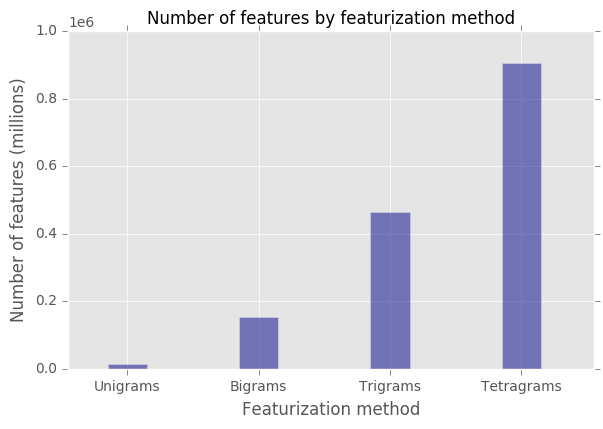

In [42]:
# Plotting number of features
from matplotlib import pyplot as plt
pos = list(range(len(num_features)))
width = 0.3

fig, ax = plt.subplots()
fig.tight_layout()

plt.bar([p + width for p in pos],
            num_features,
            width,
            alpha=0.5,
            color='darkblue',
            label='Training accuracy')

ax.set_ylabel('Number of features (millions)')
ax.set_xlabel('Featurization method')
ax.set_title('Number of features by featurization method', fontsize=12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(['Unigrams', 'Bigrams', 'Trigrams', 'Tetragrams'])

## Singular value decomposition: effects of reducing the number of features

In [151]:
from sklearn import linear_model, decomposition, datasets
from sklearn import svm
from matplotlib import pyplot as plt
from sklearn import cross_validation

plt.style.use('ggplot')

num_svd_features = [1000, 2000, 5000, 10000]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X_unigram, y, test_size=0.2, random_state=20)

def plot_accuracies(train_acc, test_acc, figure, classifier_name):
    pos = list(range(len(train_acc)))
    width = 0.2
    plt.figure(figure)
    fig, ax = plt.subplots()
    fig.tight_layout()
    
    plt.bar([p + width for p in pos],
            train_acc,
            width,
            alpha=0.5,
            color='darkblue',
            label='Training accuracy')
    
    plt.bar([p + 2 * width for p in pos],
            test_acc,
            width,
            alpha=0.5,
            color='lightsteelblue',
            label = 'Testing accuracy')
    
    simpleaxis(ax)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Number of features')
    ax.set_title('Training and testing accuracy by number of features, \n{0}'.format(classifier_name), fontsize=12)
    ax.set_xticks([p + 2 * width for p in pos])
    ax.set_xticklabels(num_svd_features)
    plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', ncol=1)    
    plt.show()

svc = svm.LinearSVC(C=10)
clfs = [('support vector classification', svc)]

for idx, (name, clf) in enumerate(clfs):
    training_accuracies = []
    testing_accuracies = []
    for n_components in num_svd_features:
        print("Working on componenents {0}".format(n_components))
        svd = decomposition.TruncatedSVD(n_components=n_components)
        svd.fit(X_train)
        X_train_transformed = svd.transform(X_train)
        X_test_transformed = svd.transform(X_test)
        clf.fit(X_train_transformed, y_train)
        training_accuracies.append(clf.score(X_train_transformed, y_train))
        testing_accuracies.append(clf.score(X_test_transformed, y_test))
    plot_accuracies(training_accuracies, testing_accuracies, idx, name)

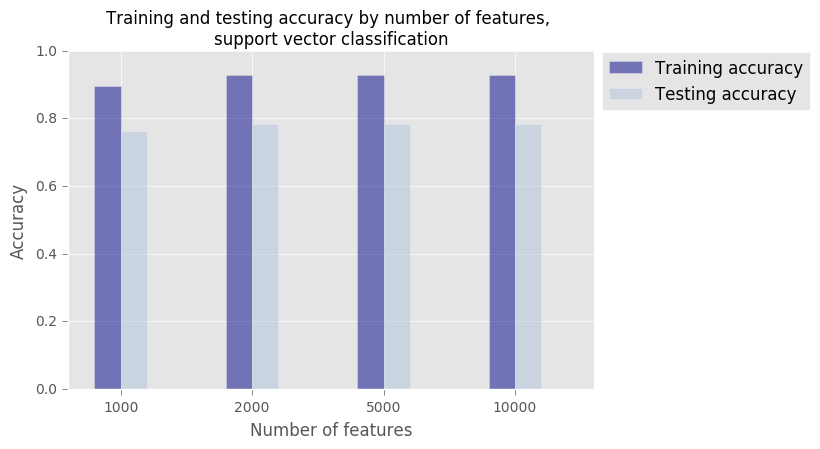

In [152]:
plot_accuracies(training_accuracies, testing_accuracies, idx, name)

# Primary classification results

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib
import csv

# SVC classification algorithms
SVC_clfs = [("Linear SVC, C=10", SVC(C=10, kernel='linear')), 
        ("Linear SVC, C=1" , SVC(C=1, kernel='linear')), 
        ("Linear SVC, C=0.1", SVC(C=0.1, kernel='linear')),
        ("Polynomial SVC, C=10", SVC(C=10, kernel='poly')),
        ("RBF SVC, C=10", SVC(C=10, kernel='rbf'))]

# Random forest algorithms
random_forest_clfs = [("Random forest, 10", RandomForestClassifier(max_features=10, max_depth=10)),
        ("Random forest, 20", RandomForestClassifier(max_features=10, max_depth=20)),
        ("Random8 forest, 30", RandomForestClassifier(max_features=10, max_depth=30)),
        ("Random forest, 60", RandomForestClassifier(max_features=10, max_depth=60))]

def get_results(clfs, filename):
    for (name, classifier) in clfs:
        print(name)
        model, X_test, y_test, X_train, y_train = train_model(X_mod, y, classifier)
        with open(filename, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Training accuracy', 'Testing accuracy'])
            writer.writerow([model.score(X_train, y_train), model.score(X_test, y_test)])
            
get_results(random_forest_clfs, "random_forest_classifier_accuracies.csv")

# ROC curves

In [ ]:
SVC_clfs = [("Linear SVC, C=10", SVC(C=10, kernel='linear')),
        ("Linear SVC, C=1" , SVC(C=1, kernel='linear')), 
        ("Linear SVC, C=0.1", SVC(C=0.1, kernel='linear')),
        ("Polynomial SVC, C=10", SVC(C=10, kernel='poly')),
        ("RBF SVC, C=10", SVC(C=10, kernel='rbf'))]

for (name, clf) in SVC_clfs:
    model, X_test, y_test, X_train, y_train = train_model(X_unigram, y, clf)
    y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    fprs[name] = fpr
    tprs[name] = tpr

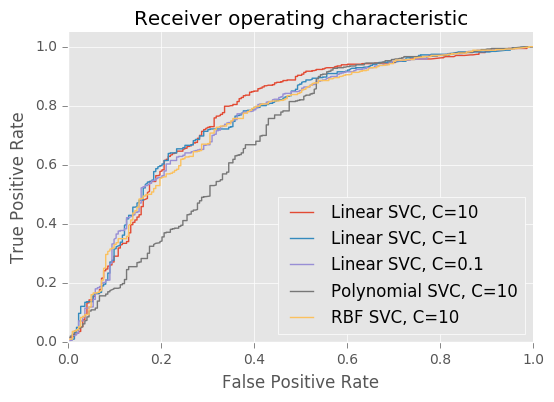

In [58]:
ax = plt.subplot()

for name, _ in SVC_clfs: 
    tpr = tprs[name]
    fpr = fprs[name]
    plt.plot(fpr, tpr, label=name)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
simpleaxis(ax)
plt.show()

# Learning curve

In [ ]:
from sklearn import utils

n_training_examples = [50, 250, 500, 1000, 1250, 1500, 1750, 2000]
training_accuracies = []
testing_accuracies = []

X_subset, X_cross_val, y_subset, y_cross_val = cross_validation.train_test_split(
        X_unigram, y, test_size=0.2, random_state=20)

for n in n_training_examples:
    svc = SVC(C=10, kernel='linear')
    X_train, y_train = utils.resample(X_subset, y_subset, replace=False, n_samples=n, random_state=20)
    svc.fit(X_train, y_train)
    training_accuracies.append(svc.score(X_train, y_train))
    testing_accuracies.append(svc.score(X_test, y_test))

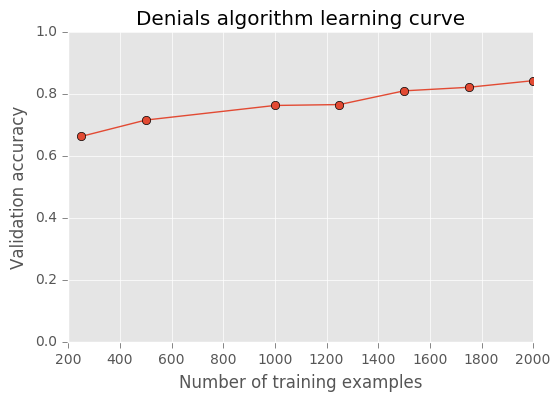

In [180]:
f, ax = plt.subplots()
plt.plot(n_training_examples[1:], testing_accuracies[1:], 'o-')
plt.ylim(0, 1)
plt.xlabel("Number of training examples")
plt.ylabel("Validation accuracy")
plt.title("Denials algorithm learning curve")
simpleaxis(ax)
plt.show()

# Repeated patents

In [208]:
top_patents = df.groupby(by='patent_id').count().sort(columns='case_id', ascending=False).case_id

/Users/davidjwiner/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [275]:
freqs = top_patents
patents = top_patents.index

sub_freqs = freqs[freqs > 1]
sub_patents = sub_freqs.index
num_denials = []
for patent in sub_patents:
    num_denials.append(sum(df[df.patent_id == patent].denied))
    
consensus = [num_denials[i] == sub_freqs[i] for i in range(len(num_denials))]

In [279]:
num_patents_without_consensus = float(sum(consensus)/float(len(num_denials)))
print("For {0} percent of patents that are duplicated across cases we have conflicting decisions".format(num_patents_without_consensus))

For 0.544827586207 percent of patents that are duplicated across cases we have conflicting decisions


In [220]:
freqs = top_patents[:10]
patents = top_patents[:10].index
num_denials = []

for patent in patents:
    num_denials.append(sum(df[df.patent_id == patent].denied))

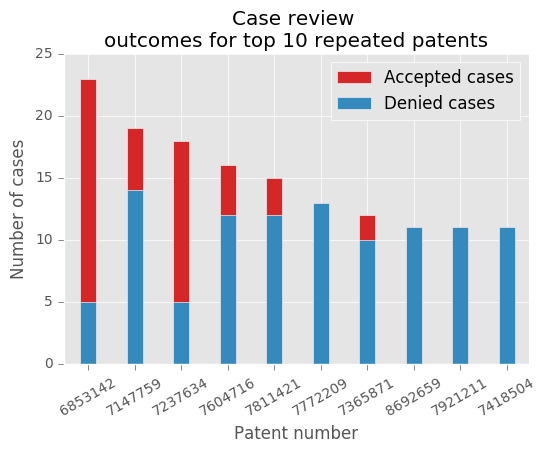

In [255]:
ind = np.arange(len(freqs))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ax = plt.subplot(111)

simpleaxis(ax)

p1 = plt.bar(ind + width, freqs, width, color='#d62728', label="Accepted cases")
p2 = plt.bar(ind + width, num_denials, width, label="Denied cases")

plt.xticks(ind + 1.5 * width, patents)
plt.xticks(rotation=30)
plt.xlabel('Patent number')
plt.ylabel('Number of cases')

plt.legend(loc='best')
plt.title('Case review \noutcomes for top 10 repeated patents')

plt.show()

# Getting most/least predictive words from SVM classifier

In [ ]:
best_clf = SVC(C=10, kernel='linear', probability=True)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X_mod, y, test_size=0.2, random_state=20)

tfidf = TfidfVectorizer()
tfidf.fit(X_mod)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

model = best_clf.fit(X_train, y_train)
vals = df.invalidated.value_counts()

In [39]:
names = tfidf.get_feature_names()
coeffs = model.coef_

In [40]:
sorted_labels = [y for (x, y) in sorted(zip(coeffs.todense(), names))]
sorted_coeffs = sorted(coeffs)

nonzeros = coeffs.nonzero()[1]
out = []

for idx in nonzeros:
    out.append((coeffs[0, idx], names[idx]))
    
sorted_labels = [y for (x, y) in sorted(out)]
sorted_coeffs = sorted(coeffs.todense().tolist()[0])

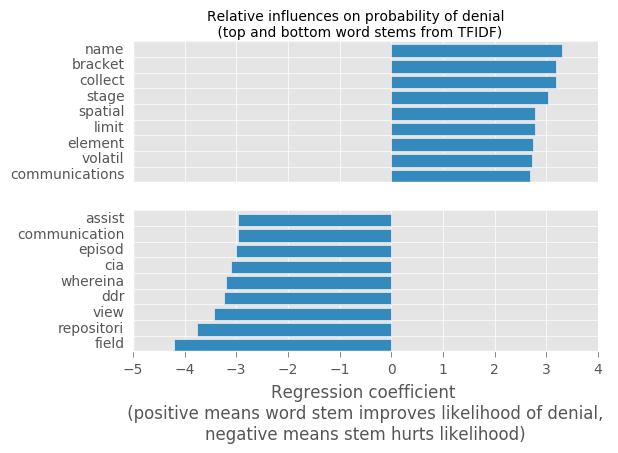

In [42]:
# Plotting

x_vals = sorted_coeffs[-10:-1] + sorted_coeffs[0:9]
least_likely_denied = sorted_labels[-10:-1]
most_likely_denied = sorted_labels[0:9]
simpleaxis(ax)

from pylab import *

pos = arange(len(x_vals))   # the bar centers on the y axis

f, axarr = plt.subplots(2, sharex=True)
plt.suptitle('Relative influences on probability of denial \n (top and bottom word stems from TFIDF)')

for ax in axarr:
    simpleaxis(ax)

x_1 = sorted_coeffs[-10:-1]
x_1_pos = arange(len(x_1))
a = axarr[0]
a.barh(x_1_pos, x_1)
a.set_yticklabels('')
# Customize minor tick labels
a.set_yticks(x_1_pos + 0.5,      minor=True)
a.set_yticklabels(least_likely_denied, minor=True)
a.tick_params(axis='both', which='both',length=0)

a = axarr[1]
x_2 = sorted_coeffs[0:9]
x_2_pos = arange(len(x_2))
a.barh(x_2_pos, x_2)
a.set_yticklabels('')

# Customize minor tick labels
a.set_yticks(x_2_pos + 0.5, minor=True)
a.set_yticklabels(most_likely_denied, minor=True)
a.tick_params(axis='y', which='both',length=0)

plt.xlabel('Regression coefficient \n (positive means word stem improves likelihood of denial, \nnegative means stem hurts likelihood)')
plt.show()